In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.arima.model import ARIMA
from datetime import timedelta

In [13]:
df = pd.read_csv('parkingLot.csv')
df['timestamp'] = pd.to_datetime(df['timestamp'])
entries_df = df[df['camera_id'] == 1]
exits_df = df[df['camera_id'] == 2]

# Merge datasets on vehicle number to calculate time spent
combined_df = entries_df.merge(exits_df, on='vehicle_no', suffixes=('_in', '_out'))
combined_df['duration'] = (combined_df['timestamp_out'] - combined_df['timestamp_in']).dt.total_seconds() / 60
filtered_df = combined_df[combined_df['duration'] > 0]

# Extract date from timestamp and compute daily average duration
filtered_df['entry_date'] = filtered_df['timestamp_in'].dt.date
avg_time_per_day = filtered_df.groupby('entry_date')['duration'].mean()
avg_time_per_day.index = pd.to_datetime(avg_time_per_day.index)
avg_time_per_day = avg_time_per_day.reindex(pd.date_range(start=avg_time_per_day.index.min(), end=avg_time_per_day.index.max(), freq='D'))
avg_time_per_day = avg_time_per_day.interpolate(method='time')

avg_time_per_day = avg_time_per_day.to_frame()
avg_time_per_day.columns = ['time_spent']

/var/folders/_s/snvdbxhj417_xkdjg8qlyl3m0000gn/T/ipykernel_94273/863364930.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_df['entry_date'] = filtered_df['timestamp_in'].dt.date


In [14]:
train_data = avg_time_per_day.iloc[:-7]
test_data = avg_time_per_day.iloc[-7:]
arima_model = ARIMA(train_data, order=(5, 1, 0)).fit()
arima_predictions = arima_model.forecast(steps=7)
ets_model = ExponentialSmoothing(train_data['time_spent'], seasonal='add', seasonal_periods=7).fit()
ets_predictions = ets_model.forecast(steps=7)

# Compute ARIMA evaluation metrics
arima_mase = mean_absolute_error(test_data, arima_predictions) / mean_absolute_error(
    train_data, [train_data.mean()] * len(train_data))
arima_mape = np.mean(np.abs((test_data - arima_predictions) / test_data)) * 100

# Prevent division by zero in MAPE calculation
epsilon = 1e-10

# Compute ARIMA evaluation metrics
arima_mase = mean_absolute_error(test_data['time_spent'], arima_predictions) / mean_absolute_error(train_data['time_spent'], [train_data['time_spent'].mean()] * len(train_data))
arima_mape = np.mean(np.abs((test_data['time_spent'] - arima_predictions) /np.where(test_data['time_spent'] == 0, epsilon, test_data['time_spent']))) * 100

ets_mase = mean_absolute_error(test_data['time_spent'], ets_predictions) /  mean_absolute_error(train_data['time_spent'], [train_data['time_spent'].mean()] * len(train_data))
ets_mape = np.mean(np.abs((test_data['time_spent'] - ets_predictions) /np.where(test_data['time_spent'] == 0, epsilon, test_data['time_spent']))) * 100
print(f"ARIMA Model -> MAE: {arima_mase:.3f}, MAPE: {arima_mape:.2f}%")
print(f"ETS Model   -> MAE: {ets_mase:.3f}, MAPE: {ets_mape:.2f}%")

ARIMA Model -> MAE: 0.088, MAPE: 94.40%
ETS Model   -> MAE: 0.109, MAPE: 130.07%


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/statsmodels/tsa/holtwinters/model.py:918: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


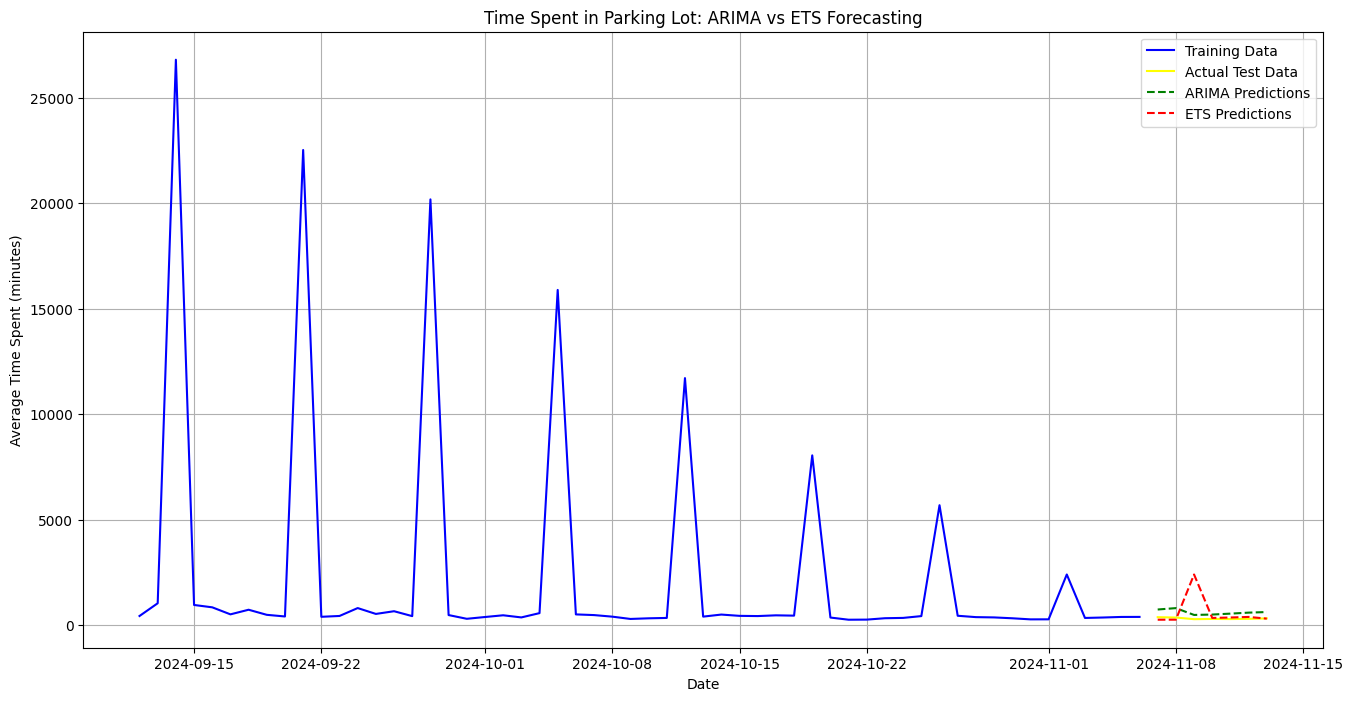

In [15]:
plt.figure(figsize=(16, 8))
plt.plot(train_data.index, train_data, label='Training Data', color='blue')
plt.plot(test_data.index, test_data, label='Actual Test Data', color='yellow')
plt.plot(test_data.index, arima_predictions, label='ARIMA Predictions', linestyle='--', color='green')
plt.plot(test_data.index, ets_predictions, label='ETS Predictions', linestyle='--', color='red')
plt.xlabel('Date')
plt.ylabel('Average Time Spent (minutes)')
plt.title('Time Spent in Parking Lot: ARIMA vs ETS Forecasting')
plt.legend()
plt.grid(True)
plt.show()